# Settings

In [2]:
USE_ALIGNZERO_GLOBAL = 0 
USE_ALIGNZERO_LOCAL = 0
USE_OFFSET = 0 
offset = 0.1
USE_BANDPASS = 0 
USE_NOTCH = 1
USE_ENVELOPE = 0
USE_ZSCORE = 0 
USE_SCALING = 0 

# USE_ALIGNZERO_GLOBAL = Substract the mean to each channel
# USE_ALIGNZERO_LOCAL 
# USE_OFFSET = Generate more windows with offset
# offset 
# USE_BANDPASS = Filter with bandpass (window by window)
# USE_ZSCORE = Filter with zscore (window by window)
# USE_SCALING = Use feature scaling

print("Settings updated")

Settings updated


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

base_paths = [
    "C:/Quick_Disk/tonge_project/data/Recordings_17_06_in_3" # sesion 3
]

# ------- Get information from individual classes
class_labels = ['none', 'left', 'left_front', 'front', 'right_front', 'right', 'swallow']

sampling_rate = 250  # Hz

all_data = []

for session_id, base_path in enumerate(base_paths, start=1):
    for class_label in class_labels:
        file_path = os.path.join(base_path, f"{class_label}.csv")
        
        try:
            # Get data from one recording and one session
            df = pd.read_csv(file_path, sep='\t', skiprows=5, engine='python')
            df.columns = [f"ch_{i}" for i in range(df.shape[1])]  # standardize column names

            # Store session 
            df["label"] = class_label
            df["session"] = session_id
            
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    print(f"Processed session: {session_id}")

# Concatenates all df vertically (axis = 0)
# Reset index means that the indexes are reset globally
# FORMAT: [ch_0, ch_1..., session] 
combined_df = pd.concat(all_data, axis=0).reset_index(drop=True)

print(f"One class combined data shape: {combined_df.shape}")

if USE_ALIGNZERO_GLOBAL == 1:
    channels = ["ch_1", "ch_2", "ch_3"]
    channel_means = combined_df[channels].mean() # Gets df with only those channels, and calculates the mean for each of the columns. 
    for ch in channels:
        combined_df[ch] = combined_df[ch] - channel_means[ch]


Processed session: 1
One class combined data shape: (288346, 26)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

def bandpass_filter(data, lowcut=5.0, highcut=50.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(signal, freq=50.0, fs=250, quality=30):
    nyquist = 0.5 * fs
    norm_freq = freq / nyquist
    b, a = iirnotch(norm_freq, quality)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iav(signal):
    return np.sum(np.abs(signal))

def rms_signed_difference(signal):
    mean_val = np.mean(signal)
    diff = signal - mean_val
    return np.sqrt(np.mean(diff**2))

def mean_frequency(signal, fs=250):
    # Compute FFT
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    power = fft_vals ** 2
    if np.sum(power) == 0:
        return 0
    mf = np.sum(freqs * power) / np.sum(power)
    return mf

def filter_window(window):
    one_window = window.copy()

    for i in range(one_window.shape[1]):  # For each channel
        if i in [0, 1, 2]:  # ch_1, ch_2, ch_3
            if USE_NOTCH == 1:
                one_window[:, i] = notch_filter(one_window[:, i])

            if USE_BANDPASS == 1:
                one_window[:, i] = bandpass_filter(one_window[:, i])

            if USE_ENVELOPE == 1:
                one_window[:, i] = compute_envelope(one_window[:, i])

            if USE_ZSCORE == 1:
                mean = one_window[:, i].mean()
                std = one_window[:, i].std()
                if std == 0:
                    std = 1
                one_window[:, i] = (one_window[:, i] - mean) / std

            if USE_ALIGNZERO_LOCAL == 1:
                mean = one_window[:, i].mean()
                one_window[:, i] = one_window[:, i] - mean

    return one_window

class_labels = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
channels = ['ch_1', 'ch_2', 'ch_3']
feature_names = ['RMS', 'RMS_SD', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV']
feature_names = ['RMS', 'ZC', 'WL', 'MAV']

def extract_features_single_window(window):
    feats = []
    for ch_idx in range(len(channels)):
        ch_signal = window[:, ch_idx]
        feats.append(rms(ch_signal))
        #feats.append(rms_signed_difference(ch_signal))
        feats.append(zero_crossings(ch_signal))
        feats.append(waveform_length(ch_signal))
        feats.append(mav(ch_signal))
        #feats.append(np.std(ch_signal))
        #feats.append(np.var(ch_signal))
        #feats.append(iav(ch_signal))
    
    # Build column names
    cols = []
    for ch in channels:
        for feat_name in feature_names:
            cols.append(f"{ch}_{feat_name}")
    
    X = pd.DataFrame([feats], columns=cols)  # shape: (1, num_features)
    return X
    
# Define window size
window_size = 375
overlap = 350
step_size = window_size - overlap
class_type = 'right'
channels = ["ch_1", "ch_2", "ch_3"]

# Number of full windows that can be obtained
num_windows = (len(combined_df) - window_size) // step_size + 1

for i in range(num_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size

    window_df = combined_df.iloc[start_idx:end_idx]

    # Check if all samples in the window have the target class
    if not (window_df["label"] == class_type).all():
        continue  # Skip this window

    # Extract only the channel data
    window_np = window_df[channels].values

    # Filter the current window
    filtered_window = filter_window(window_np)

    # Get features of the window
    X = extract_features_single_window(filtered_window)

    # Predict
    clf_RF = joblib.load("6_classes_rf_17_09.pkl")

    if USE_SCALING == 1:
        Xt_scaled_array = scaler_RF.transform(X)
        Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
        y_pred = clf_RF.predict(Xt_scaled)
    else:
        y_pred = clf_RF.predict(X)

    print(y_pred)
    


['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n']
['n'

KeyboardInterrupt: 

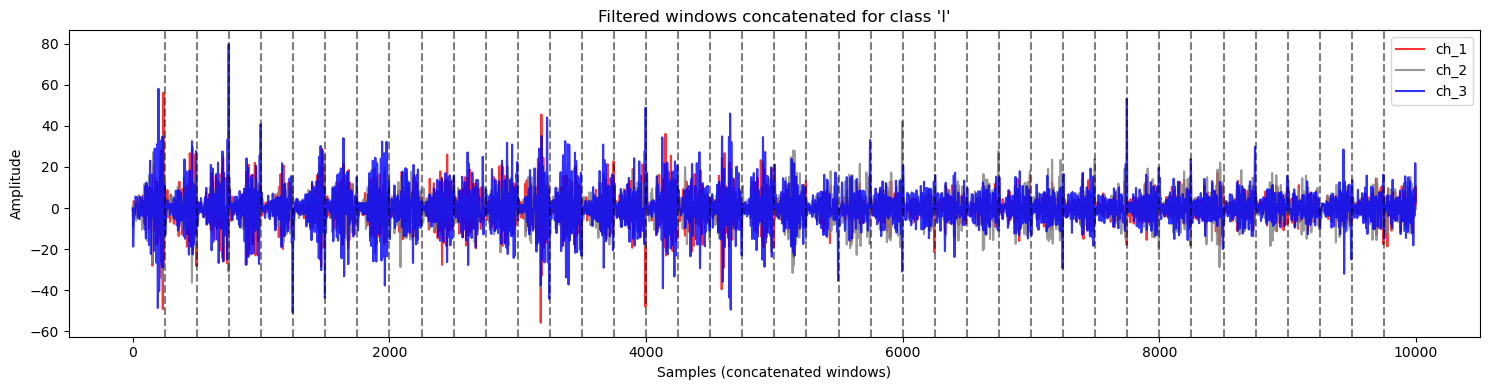

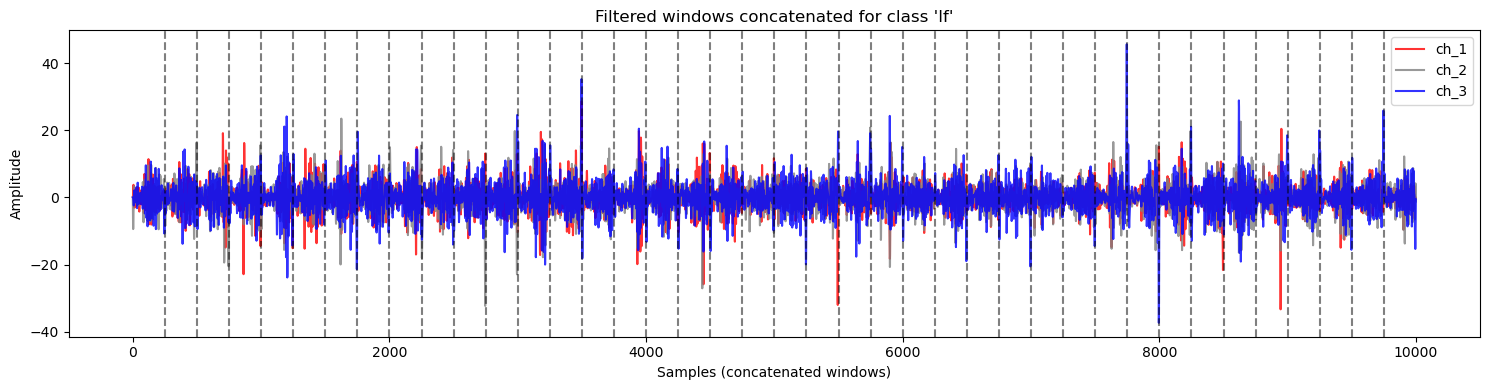

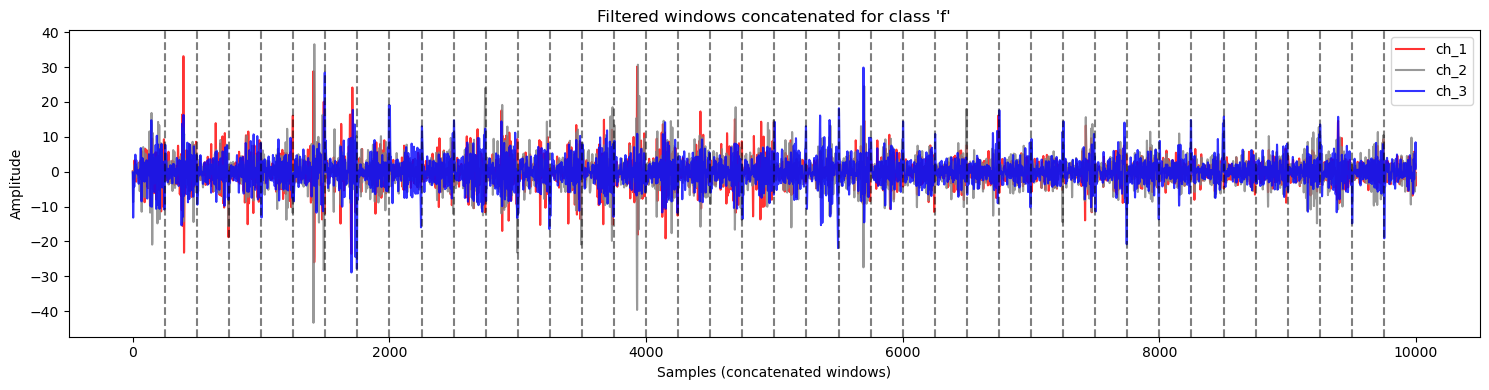

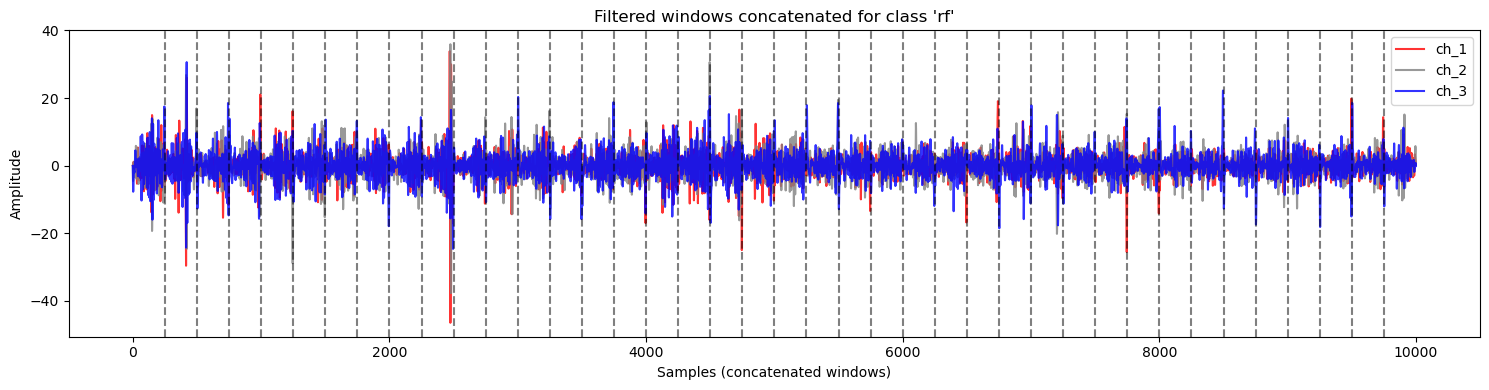

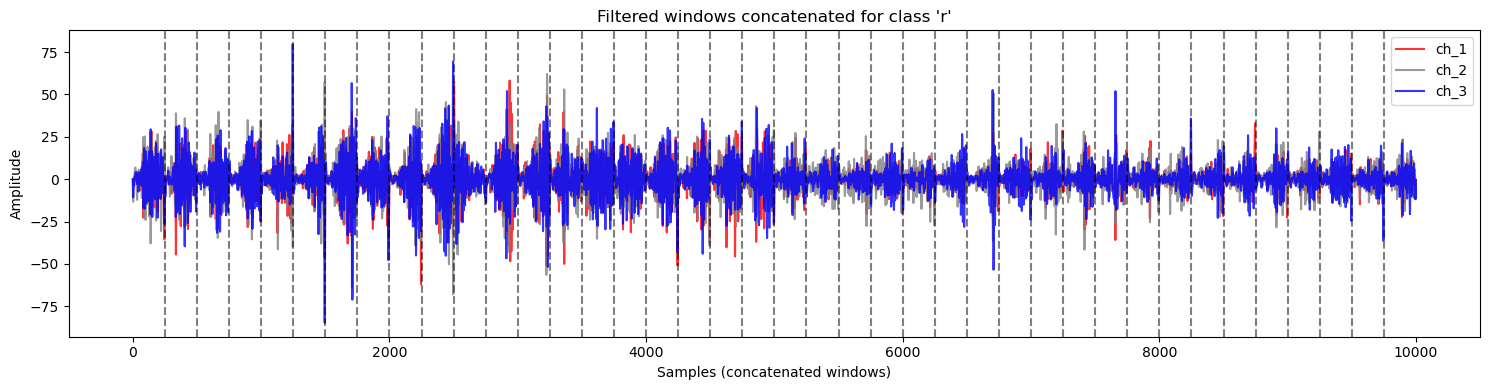

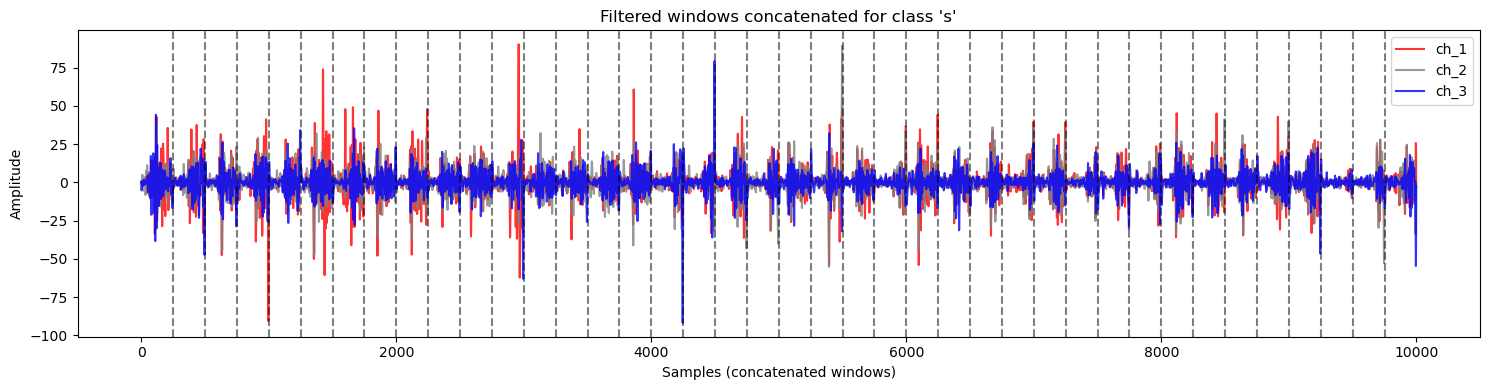

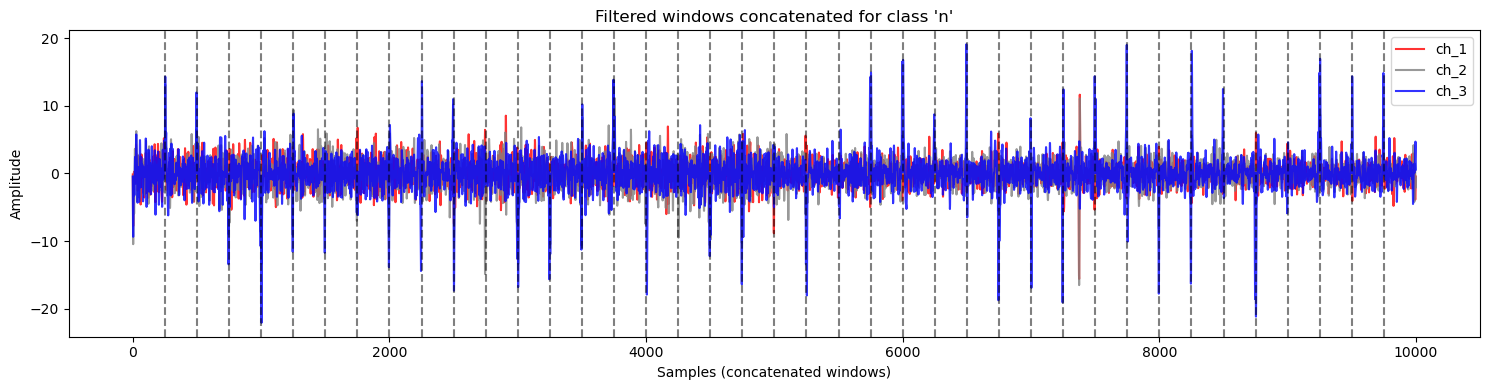

In [11]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


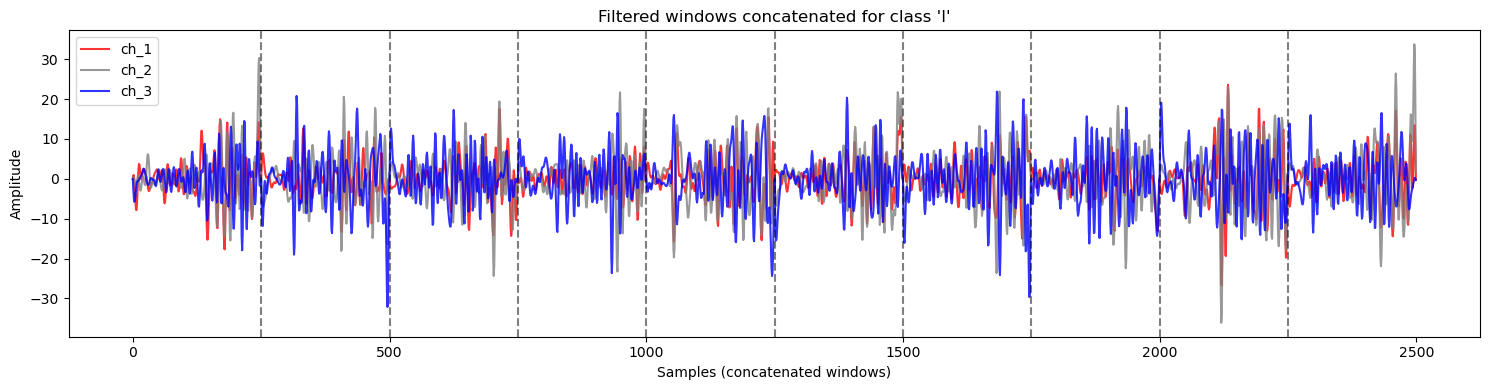

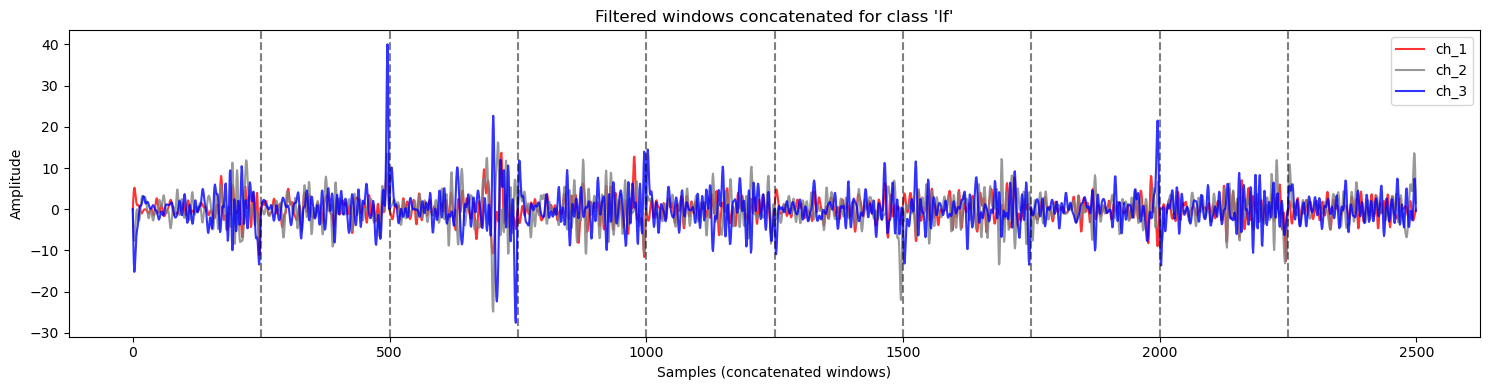

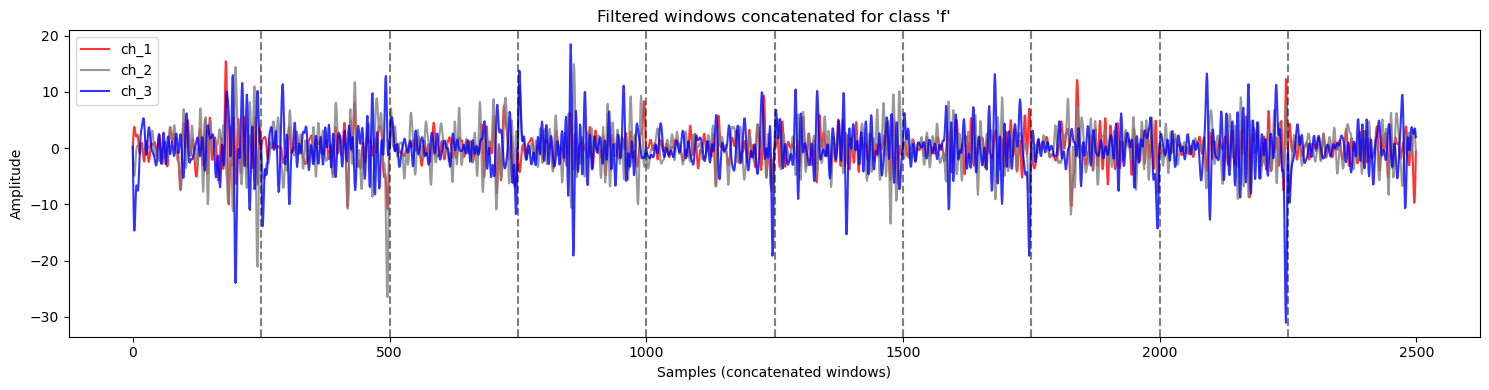

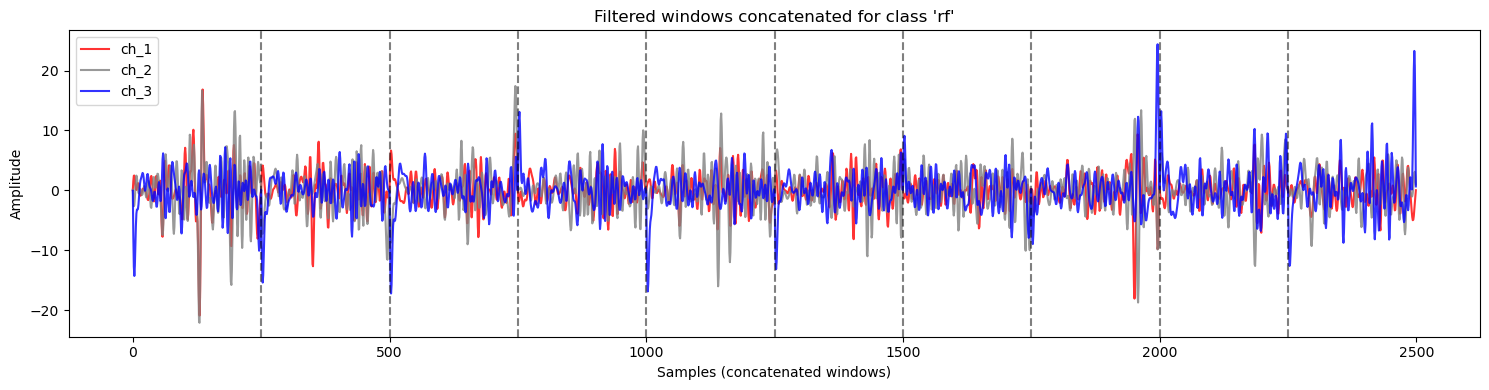

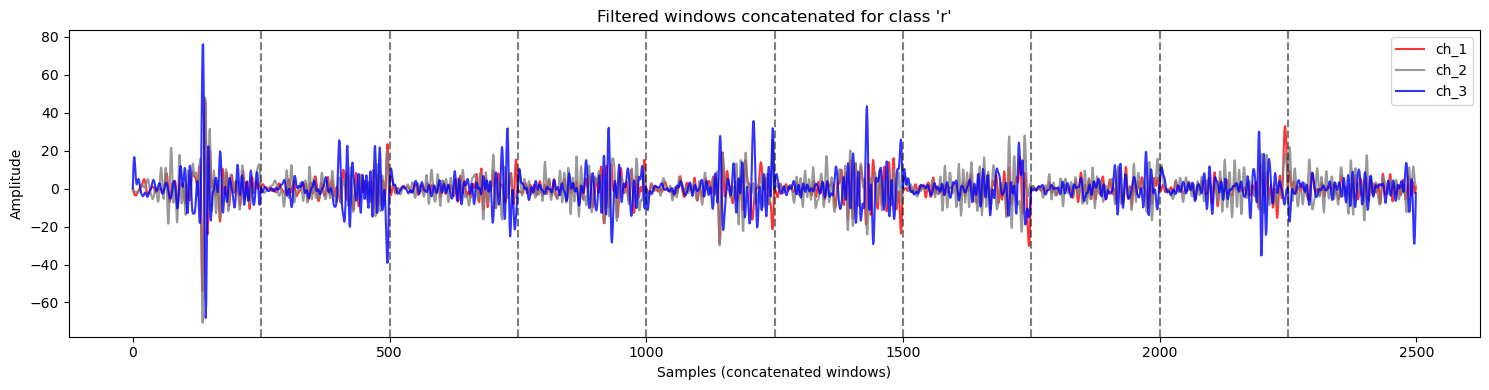

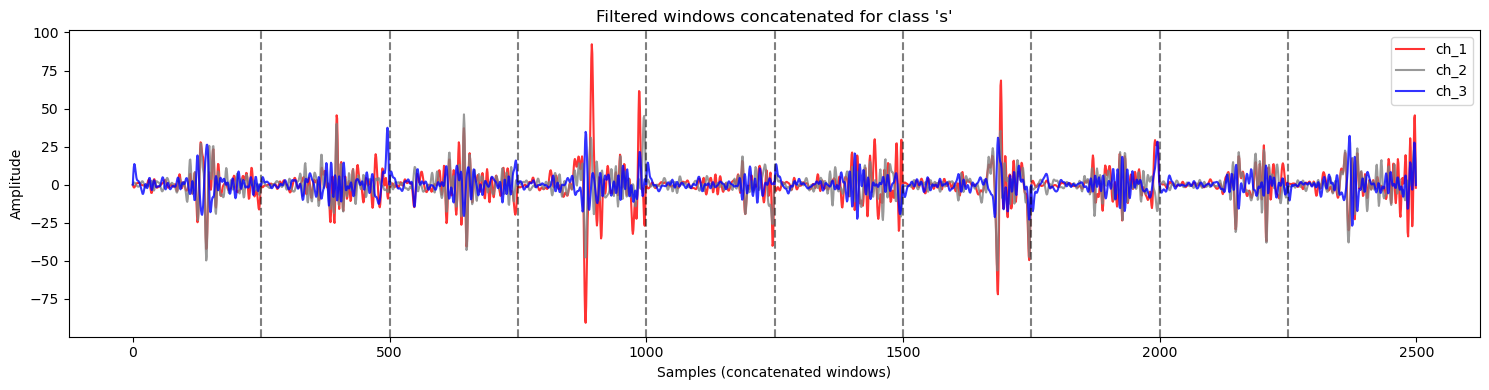

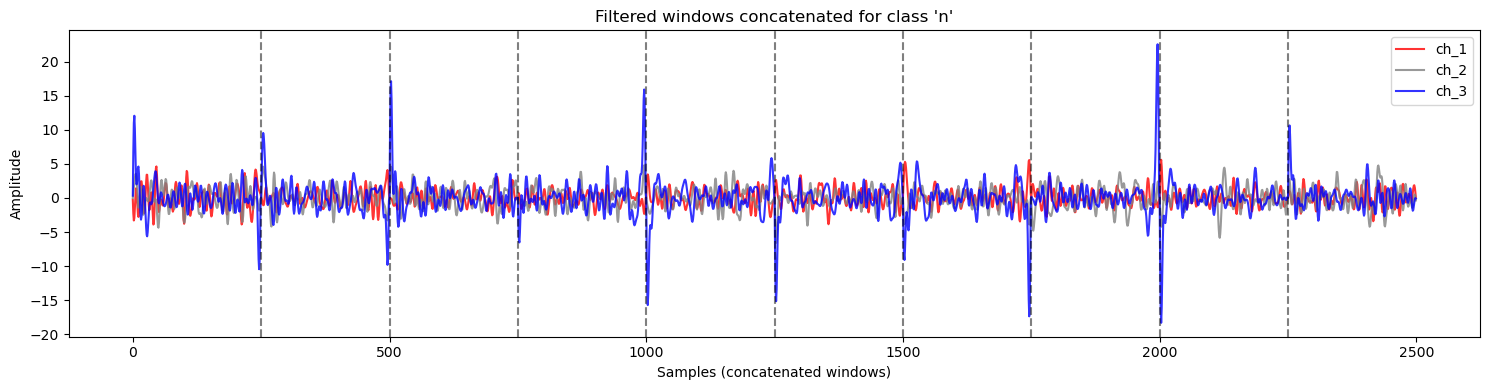

In [12]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered_test.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


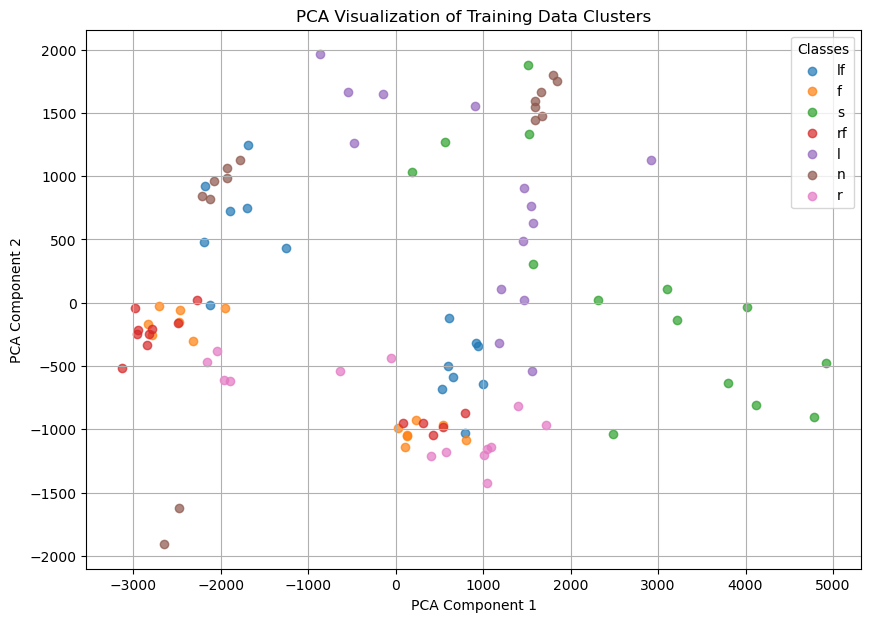

In [11]:
from sklearn.decomposition import PCA

# 2.5 PCA for visualization (2D)
pca = PCA(n_components=2)

if USE_SCALING == 1:
    X_train_pca = pca.fit_transform(X_train_scaled)
else:
    X_train_pca = pca.fit_transform(X_train)

# Plot
plt.figure(figsize=(10, 7))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Training Data Clusters')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


SVM Test Accuracy: 0.279


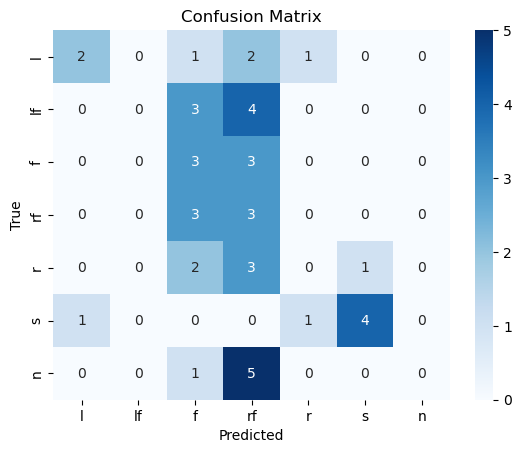

In [156]:
# ----------------------------- SUPPORT VECTOR MACHINE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_SVM = StandardScaler()
X_train_scaled_array = scaler_SVM.fit_transform(X_train)
X_test_scaled_array = scaler_SVM.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_SVM = SVC(kernel='rbf', C=0.1, gamma='scale', class_weight='balanced')
if USE_SCALING == 1:
    clf_SVM.fit(X_train_scaled, y_train) # with scaling
    y_pred = clf_SVM.predict(X_test_scaled)
else:
    clf_SVM.fit(X_train, y_train)
    y_pred = clf_SVM.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"SVM Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_SVM, "7_classes_svm.pkl")
#joblib.dump(scaler, "scaler_SVM_svm.pkl")


C:\Users\amebita\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\amebita\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Test Accuracy: 0.651


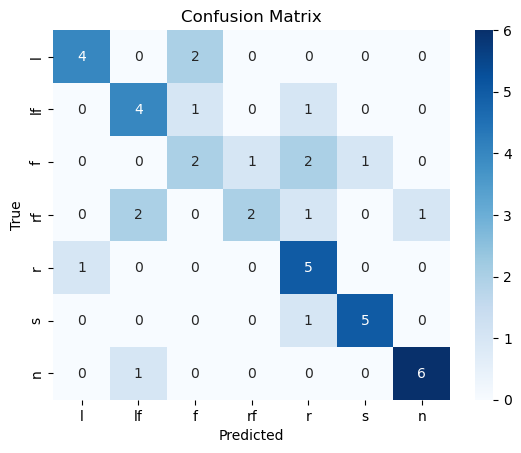

In [129]:
# ------------------------------- LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_LR = StandardScaler()
X_train_scaled_array = scaler_LR.fit_transform(X_train)
X_test_scaled_array = scaler_LR.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_LR = LogisticRegression(
    solver='lbfgs', 
    multi_class='multinomial', 
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

if USE_SCALING == 1:
    clf_LR.fit(X_train_scaled, y_train)  # with scaling
    y_pred = clf_LR.predict(X_test_scaled)
else:
    clf_LR.fit(X_train, y_train)
    y_pred = clf_LR.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Logistic Regression Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_LR, "6_classes_lr.pkl")
#joblib.dump(scaler_LR, "6_classes_scaler_lr.pkl")


SVM Test Accuracy: 0.329


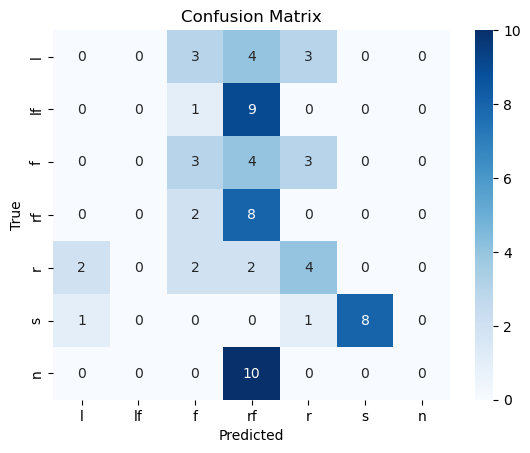

In [158]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_SVM.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_SVM.predict(Xt_scaled)
else:
    y_pred = clf_SVM.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"SVM Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Logistic Regression Test Accuracy: 0.493


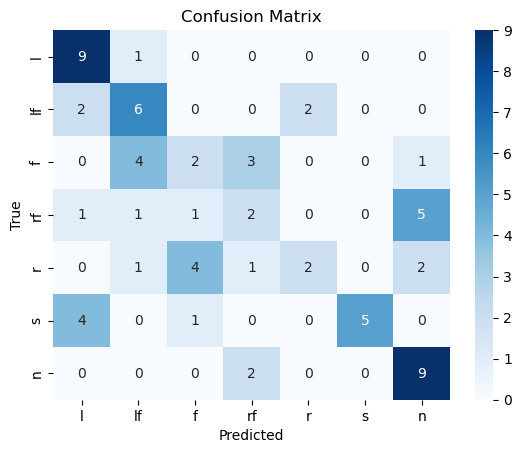

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_LR.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_LR.predict(Xt_scaled)
else:
    y_pred = clf_LR.predict(Xt)

# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Logistic Regression Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Optional: Plot coefficients if you want (commented out for now)
# coefs = clf_LR.coef_
# feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]
# plt.figure(figsize=(12,6))
# for i, class_label in enumerate(clf_LR.classes_):
#     plt.plot(feature_names, coefs[i], marker='o', label=f"Class {class_label}")
# plt.title("Logistic Regression Coefficients")
# plt.ylabel("Coefficient Value")
# plt.xticks(rotation=45, ha='right')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
